In [1]:
#müşteri arıza classification analizi
#öncelikle gerekli kütüphaneler yükleniyor
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve



C:\Users\185681\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [ ]:
#pip install --upgrade pip --user
#pip install --upgrade numpy --user

In [2]:
#oracle plsql ile ayarladığımız veri seti yükleniyor
df = pd.read_table('musteri_ariza_classification_data.txt')

In [3]:
#veride boş kolon bulunmuyor, hizmet kalitesi kolonu object, bunu float a dönüştürme
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10936 entries, 0 to 10935
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   MUSTERI_ARIZA          10936 non-null  int64 
 1   ALTYAPI                10936 non-null  int64 
 2   SANTRAL_MESAFESI       10936 non-null  int64 
 3   ATTENUATION_DOWN       10936 non-null  int64 
 4   NOISE_MARGIN_UP        10936 non-null  int64 
 5   HIZMET_KALITESI        10936 non-null  object
 6   STABILITY              10936 non-null  object
 7   HIZMET_KALITESI_DIGIT  10936 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 683.6+ KB


In [4]:
#hizmet kalitesi kolonu object, bunu float a dönüştürme
df['HIZMET_KALITESI']=df['HIZMET_KALITESI'].str.replace(',', '.').astype(float)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10936 entries, 0 to 10935
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MUSTERI_ARIZA          10936 non-null  int64  
 1   ALTYAPI                10936 non-null  int64  
 2   SANTRAL_MESAFESI       10936 non-null  int64  
 3   ATTENUATION_DOWN       10936 non-null  int64  
 4   NOISE_MARGIN_UP        10936 non-null  int64  
 5   HIZMET_KALITESI        10936 non-null  float64
 6   STABILITY              10936 non-null  object 
 7   HIZMET_KALITESI_DIGIT  10936 non-null  int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 683.6+ KB


In [6]:
df

,MUSTERI_ARIZA,ALTYAPI,SANTRAL_MESAFESI,ATTENUATION_DOWN,NOISE_MARGIN_UP,HIZMET_KALITESI,STABILITY,HIZMET_KALITESI_DIGIT
0,0,2,253,12,16,1.000,STABLE,1
1,0,2,250,10,17,1.000,STABLE,1
2,1,1,812,16,20,0.875,STABLE,1
3,0,2,802,16,9,0.710,STABLE,0
4,0,1,773,13,6,1.000,STABLE,1
...,...,...,...,...,...,...,...,...
10931,1,1,503,17,10,0.958,STABLE,1
10932,0,1,1293,23,18,0.809,STABLE,1
10933,0,1,1182,25,18,1.000,STABLE,1
10934,0,1,875,20,20,1.000,STABLE,1


In [7]:
#STABILITY KOLONU CHAR, bunu one code encoding yapma
#STBLTY = pd.get_dummies(df.STABILITY)

In [7]:
#df_son = df.join(STBLTY)
df_son = df

In [8]:
df_son

,MUSTERI_ARIZA,ALTYAPI,SANTRAL_MESAFESI,ATTENUATION_DOWN,NOISE_MARGIN_UP,HIZMET_KALITESI,STABILITY,HIZMET_KALITESI_DIGIT
0,0,2,253,12,16,1.000,STABLE,1
1,0,2,250,10,17,1.000,STABLE,1
2,1,1,812,16,20,0.875,STABLE,1
3,0,2,802,16,9,0.710,STABLE,0
4,0,1,773,13,6,1.000,STABLE,1
...,...,...,...,...,...,...,...,...
10931,1,1,503,17,10,0.958,STABLE,1
10932,0,1,1293,23,18,0.809,STABLE,1
10933,0,1,1182,25,18,1.000,STABLE,1
10934,0,1,875,20,20,1.000,STABLE,1


In [9]:
#artık stability kolonuna gerek kalmadı, droplanıyor ve tablo yapısı inceleniyor
df_son = df_son.drop('STABILITY', axis=1)
df_son = df_son.drop('HIZMET_KALITESI_DIGIT', axis=1)
df_son.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10936 entries, 0 to 10935
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MUSTERI_ARIZA     10936 non-null  int64  
 1   ALTYAPI           10936 non-null  int64  
 2   SANTRAL_MESAFESI  10936 non-null  int64  
 3   ATTENUATION_DOWN  10936 non-null  int64  
 4   NOISE_MARGIN_UP   10936 non-null  int64  
 5   HIZMET_KALITESI   10936 non-null  float64
dtypes: float64(1), int64(5)
memory usage: 512.8 KB


In [10]:
#hedefimiz müşteri arıza kolonunu tahminleme, öncelikle test-train ayrımı yapma
x_train, x_test, y_train, y_test = train_test_split(df_son.iloc[:,1:], df_son['MUSTERI_ARIZA'],
                                                    test_size=0.3, random_state=42) 

In [11]:
#rf
rf = RandomForestClassifier()

acc_rf = cross_val_score(rf, x_train, y_train, cv=5, scoring='accuracy')
acc_rf

array([0.95035924, 0.95035924, 0.94774657, 0.94839974, 0.95231875])

In [12]:
#decision tree
dt = DecisionTreeClassifier() 

acc_dt = cross_val_score(dt, x_train, y_train, cv=5, scoring='accuracy')
acc_dt

array([0.91378184, 0.910516  , 0.91574135, 0.91574135, 0.91574135])

In [13]:
#xgboost
xgboost = XGBClassifier()

acc_xgboost = cross_val_score(xgboost, x_train, y_train, cv=5, scoring='accuracy')
acc_xgboost

array([0.95231875, 0.94970607, 0.95101241, 0.94839974, 0.95035924])

In [14]:
#decision tree dışına çıkınca scaling lazım
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler()

x_train_scaled = std_scale.fit_transform(x_train)
x_test_scaled = std_scale.transform(x_test)

In [15]:
#scaling yapıldı ve logreg
logreg = LogisticRegression(solver='liblinear')

acc_logreg = cross_val_score(logreg, x_train_scaled, y_train, cv=5, scoring='accuracy')
acc_logreg

array([0.95362508, 0.95362508, 0.95362508, 0.95362508, 0.95427825])

In [16]:
#knn=5 olarak 
knn = KNeighborsClassifier()

acc_knn = cross_val_score(knn, x_train_scaled, y_train, cv=5, scoring='accuracy')
acc_knn

array([0.95297191, 0.95362508, 0.95035924, 0.95166558, 0.95297191])

In [17]:
#perceptron
perceptron = Perceptron()

acc_perc = cross_val_score(perceptron, x_train_scaled, y_train, cv=5, scoring='accuracy')
acc_perc

array([0.95362508, 0.92357936, 0.94905291, 0.91835402, 0.95101241])

In [18]:
#svc
svc = SVC()

acc_svc = cross_val_score(svc, x_train_scaled, y_train, cv=5, scoring='accuracy')
acc_svc

array([0.95362508, 0.95362508, 0.95362508, 0.95362508, 0.95427825])

In [19]:
#bütün modelleri kıyaslayarak en uygun modeli bulma
results = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'XGBoost',
              'Logistic Regression', 'KNN', 'Perceptron', 'SVC'],
    'Cross Validated Score (Mean)': [acc_rf.mean(), acc_dt.mean(), acc_xgboost.mean(), acc_logreg.mean(),
                                     acc_knn.mean(), acc_perc.mean(), acc_svc.mean()],
    'Cross Validated Score (Std)': [acc_rf.std(), acc_dt.std(), acc_xgboost.std(), acc_logreg.std(),
                                    acc_knn.std(), acc_perc.std(), acc_svc.std()]})

result_df = results.sort_values(by='Cross Validated Score (Mean)', ascending=False)
result_df = result_df.set_index('Model')
result_df['Cross Validated Score (Mean)'] = (result_df['Cross Validated Score (Mean)']*100).round(2)
result_df['Cross Validated Score (Std)'] = (result_df['Cross Validated Score (Std)']*100).round(2)
result_df

,Cross Validated Score (Mean),Cross Validated Score (Std)
Model,,
Logistic Regression,95.38,0.03
SVC,95.38,0.03
KNN,95.23,0.12
XGBoost,95.04,0.13
Random Forest,94.98,0.16
Perceptron,93.91,1.50
Decision Tree,91.43,0.20


In [20]:
##model olarak en etkili Logistic Regression göründüğü için bu modelle başlanıyor

In [21]:
#hedefimiz müşteri arıza kolonunu tahminleme, öncelikle test-train ayrımı yapma
X_train, X_test, y_train, y_test = train_test_split(df_son.iloc[:,1:], df_son['MUSTERI_ARIZA'],
                                                    test_size=0.3, random_state=42) 

In [22]:
# Logistic Regresyon modelini oluşturma ama öncesinde scaling yapmak gerekiyor
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()

X_train_transformed = scale.fit_transform(X_train)
X_test_transformed = scale.transform(X_test)

logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train_transformed, y_train)
logreg.score(x_test_scaled, y_test)


0.9542822310271258

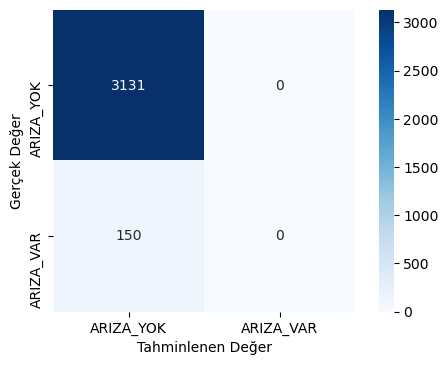

In [23]:
#log reg conf matrix
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(model, threshold=0.5): # threshold default 0.5
    y_predict = (model.predict_proba(x_test_scaled)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=100)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['ARIZA_YOK', 'ARIZA_VAR'],
           yticklabels=['ARIZA_YOK', 'ARIZA_VAR']);
    plt.xlabel('Tahminlenen Değer')
    plt.ylabel('Gerçek Değer')
    
make_confusion_matrix(logreg) # En başarılı olan modelimiz

In [24]:
#tahminleme başarı oranı(detaylı)
def evaluate_model(model, X, y, pred_label=0):
    
    y_pred = model.predict(X)

    accuracy = round(accuracy_score(y, y_pred), 3)
    recall = round(recall_score(y, y_pred, pos_label = pred_label), 3)
    precision = round(precision_score(y, y_pred, pos_label = pred_label), 3)
    f1 = round(f1_score(y, y_pred, pos_label = pred_label), 3)
    auc_score = round(roc_auc_score(y, y_pred), 3)

    metric_df = pd.DataFrame([accuracy, recall, precision, f1, auc_score]).T
    metric_df.index = ["Müşteri ariza " + str(pred_label)]
    metric_df.columns = ["Accuracy", "Recall", "Precision", "F1 Score", "AUC Score"]

    return metric_df

In [25]:
#arıza bırakmayan aboneleri çok güzel yakalamış fakat bırakanları yakalayamamış
evaluate_model(logreg, X_test_transformed, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Müşteri ariza 0,0.954,1.0,0.954,0.977,0.5


In [26]:
#arıza bırakmayan aboneleri çok güzel yakalamış fakat bırakanları yakalayamamış
evaluate_model(logreg, X_test_transformed, y_test, pred_label=1)

C:\Users\185681\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Recall,Precision,F1 Score,AUC Score
Müşteri ariza 1,0.954,0.0,0.0,0.0,0.5


In [27]:
#Bu noktada arıza olmayan müşterileri sorunsuz yakalarken, arıza yok olanları da arıza var olarak yakalamış
#bu hatayı düzeltmek için öncelikle treshold değeri manuel ayarlanıyor

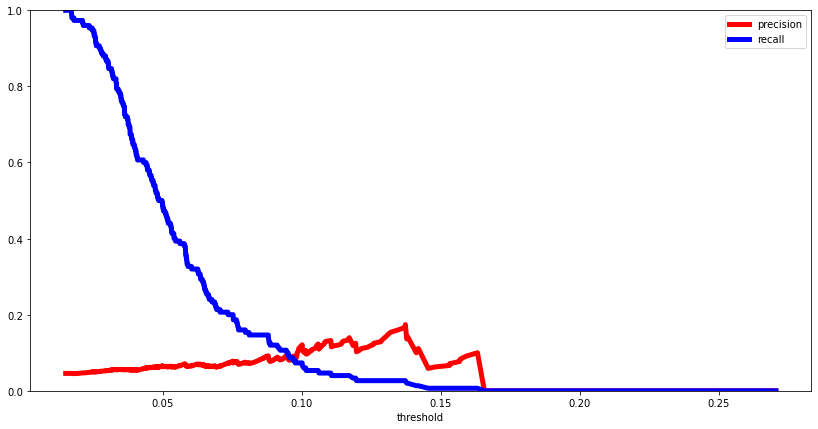

In [28]:
#recall ve precision inceleme
from sklearn.metrics import precision_recall_curve

y_scores = logreg.predict_proba(x_test_scaled)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_test, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=10)
    plt.legend(loc="upper right", fontsize=10)
    plt.ylim([0, 1])

plt.figure(figsize=[14, 7])
plot_precision_and_recall(precision, recall, threshold)

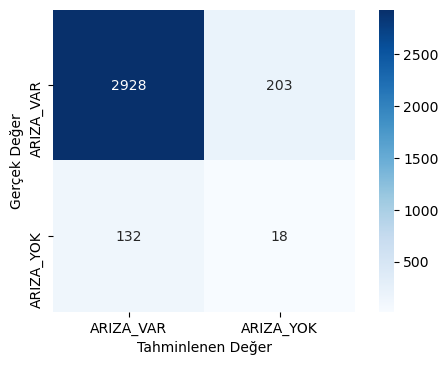

In [29]:
#conf matrix deneme 2, bu sefer treshold değeri 0.09 olarak alınıyor
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(model, threshold=0.09):
    y_predict = (model.predict_proba(x_test_scaled)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=100)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['ARIZA_VAR', 'ARIZA_YOK'],
           yticklabels=['ARIZA_VAR', 'ARIZA_YOK']);
    plt.xlabel('Tahminlenen Değer')
    plt.ylabel('Gerçek Değer')
    
make_confusion_matrix(logreg) # En başarılı olan modelimiz

In [30]:
#treshold değeri el ile ayarlanıyor

from ipywidgets import interactive

interactive(lambda threshold: make_confusion_matrix(logreg, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

ROC AUC Score= 0.601


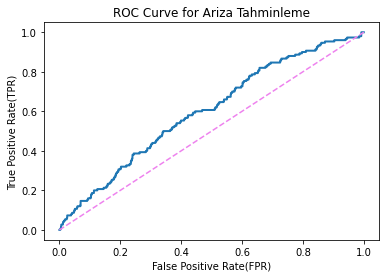

In [31]:
#area under curve değeri 1 e yakın olmalı, sol yukarıda olmalı, 0.6 bu örnekte

fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_transformed)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC Curve for Ariza Tahminleme');
print("ROC AUC Score=", round(roc_auc_score(y_test, logreg.predict_proba(X_test_transformed)[:,1]),3))

In [32]:
#log loss değeri 0 a yakın olmalı
from sklearn.metrics import log_loss

print("Log-Loss on LogReg: {:6.3f}".format(log_loss(y_test, logreg.predict_proba(X_test_transformed))))

Log-Loss on LogReg:  0.184


In [33]:
#treshold değerini değiştirmek te modele fayda sağlamadı, veri dengesiz bir veri olduğu için
#oversampling ve undersampling denenecek
!pip install mlxtend
!pip install joblib
!pip install imblearn --user

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter
from mlxtend.plotting import plot_decision_regions

In [35]:
#veri seti imbalanced olarak ayarlanıyor
imbalanced_df=df_son

In [36]:
#tahmin edeceğimiz kolon target, bi count una bakalım
target_count = imbalanced_df.MUSTERI_ARIZA.value_counts(normalize=True)
target_count

MUSTERI_ARIZA
0    0.953914
1    0.046086
Name: proportion, dtype: float64

In [37]:
#dengesiz bir dağılım var, bu yüzden
#oversampling yapılıyor
#oversampling-->az olan veri kümesini çok olana yaklaştırıyor, %2 olan değeri %98 olan değere yaklaştıracak
X = imbalanced_df.iloc[:, 1:]#2. kolondan itibaren al demek
y = imbalanced_df.MUSTERI_ARIZA #benim tahminleyeceğim kolon
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# stratify=y parametresi veri setini bölme aşamasında train ve testteki label dağılımının dengeli olacağını söyler

In [38]:
##conf matrix oluşturuluyor, 
def print_confusion_matrix(confusion_matrix, class_names, figsize = [12,8], fontsize=18):
       
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=figsize)
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [39]:
#oversampling yöntem:1
#Bu teknik, azınlık sınıfındaki örneklerin tamamen rastgele kopyalarını oluşturarak, 
#veri setindeki sınıfların dengesini sağlar.
#trainleri oversampling yap
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [40]:
#8k 8k arıza ve olmayan
Counter(y_resampled)

Counter({0: 7302, 1: 7302})

In [41]:
#Support Vector Classifier (SVC) random over sampling uygulanıyor, analiz biraz uzun
svc_ros = SVC().fit(X_resampled, y_resampled)

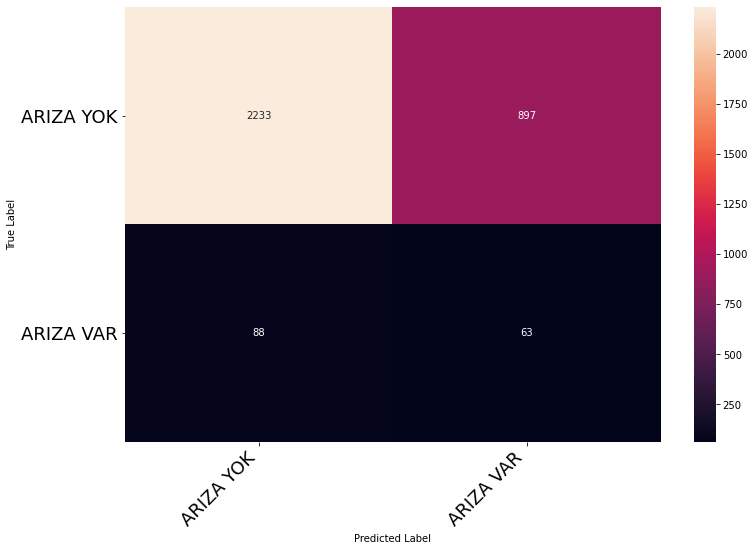

In [42]:
#malesef arıza yok grubunu bozdu fakat arıza varları yakaladı
print_confusion_matrix(confusion_matrix(y_test, svc_ros.predict(X_test)), ['ARIZA YOK', 'ARIZA VAR'])

In [43]:
#accr presicion ve f1 değeri hesaplanıyor ariza=1 için
evaluate_model(svc_ros, X_resampled, y_resampled, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Müşteri ariza 1,0.569,0.423,0.598,0.495,0.569


In [44]:
#accr presicion ve f1 değeri hesaplanıyor ariza=0 için
evaluate_model(svc_ros, X_resampled, y_resampled, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Müşteri ariza 0,0.569,0.715,0.553,0.624,0.569


In [45]:
#2 oversampling yöntemi #ADASYN (Adaptive Synthetic Oversampling)

In [46]:
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN().fit_resample(X_train, y_train)

In [47]:
#Counter({0: 29017, 1: 28976}) değerleri yakın
Counter(y_adasyn)

Counter({0: 7302, 1: 7325})

In [48]:
#modeli oluştur
svc_adasyn = SVC().fit(X_adasyn, y_adasyn)

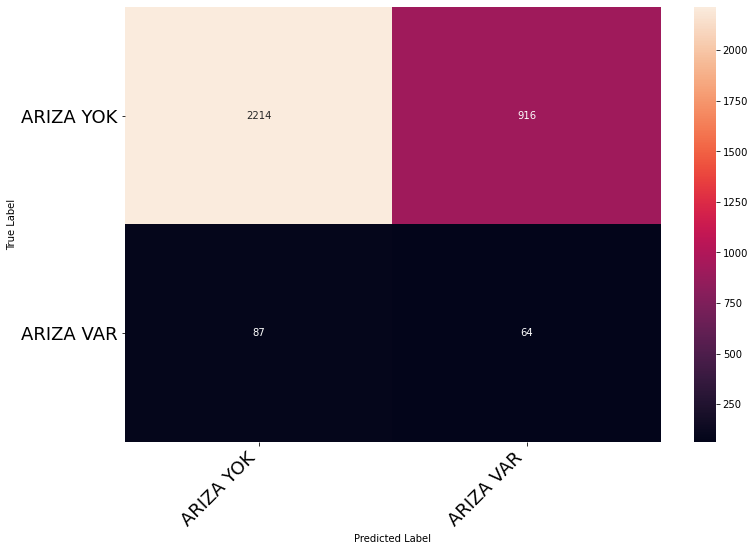

In [49]:
#conf matrix 1 de hata var bunda, sanki 2. smote daha iyi gibi ama ihtiyaca göre değişir
print_confusion_matrix(confusion_matrix(y_test, svc_adasyn.predict(X_test)), ['ARIZA YOK', 'ARIZA VAR'])

In [50]:
#accr presicion ve f1 değeri hesaplanıyor ma:1
evaluate_model(svc_adasyn, X_adasyn, y_adasyn, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Müşteri ariza 1,0.568,0.426,0.596,0.497,0.568


In [51]:
#accr presicion ve f1 değeri hesaplanıyor ma:0
evaluate_model(svc_adasyn, X_adasyn, y_adasyn, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Müşteri ariza 0,0.568,0.711,0.552,0.622,0.568


In [52]:
#3. yöntem Borderline-SMOTE(2 ve 3 ün karışımı)
from imblearn.over_sampling import BorderlineSMOTE
X_blsmote, y_blsmote = BorderlineSMOTE().fit_resample(X_train, y_train)

In [53]:
#0 ve 1 aynı
Counter(y_blsmote)

Counter({0: 7302, 1: 7302})

In [54]:
#modeli oluştur
svc_blsmote = SVC().fit(X_blsmote, y_blsmote)

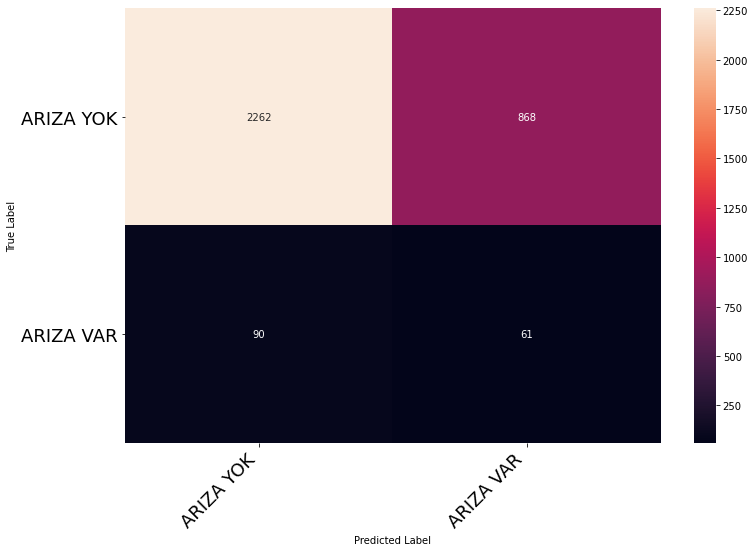

In [55]:
##son oversampling yöntemi
print_confusion_matrix(confusion_matrix(y_test, svc_blsmote.predict(X_test)), ['ARIZA YOK', 'ARIZA VAR'])

In [56]:
#accr presicion ve f1 değeri hesaplanıyor ma:1
evaluate_model(svc_blsmote, X_blsmote, y_blsmote, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Müşteri ariza 1,0.644,0.561,0.672,0.612,0.644


In [57]:
#accr presicion ve f1 değeri hesaplanıyor ma:0
evaluate_model(svc_blsmote, X_blsmote, y_blsmote, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Müşteri ariza 0,0.644,0.727,0.623,0.671,0.644


In [58]:
#undersampling yöntemi
from imblearn.under_sampling import RandomUnderSampler
X_under, y_under = RandomUnderSampler().fit_resample(X_train, y_train)

In [59]:
#adetler birbirine yakın
Counter(y_under)

Counter({0: 353, 1: 353})

In [60]:
#gmodeli eğit
svc_rus = SVC().fit(X_under, y_under)

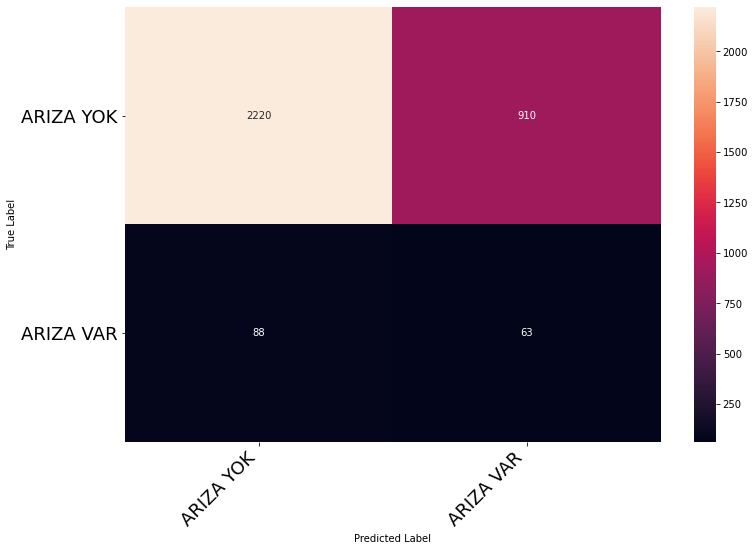

In [61]:
#undersampling conf matrix/bu model veri sayısı az olduğu için sonucu kötü çıkıyor
print_confusion_matrix(confusion_matrix(y_test, svc_rus.predict(X_test)), ['ARIZA YOK', 'ARIZA VAR'])

In [62]:
#accr presicion ve f1 değeri hesaplanıyor ma:1
evaluate_model(svc_rus, X_under, y_under, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Müşteri ariza 1,0.599,0.433,0.648,0.52,0.599


In [63]:
#accr presicion ve f1 değeri hesaplanıyor ma:0
evaluate_model(svc_rus, X_under, y_under, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Müşteri ariza 0,0.599,0.765,0.574,0.656,0.599


In [64]:
#son olarak bir de random forest algoritması deneniyor
!pip install shap --user

ERROR: Could not find a version that satisfies the requirement python-dateutil>=2.8.2 (from pandas->shap) (from versions: none)
ERROR: No matching distribution found for python-dateutil>=2.8.2 (from pandas->shap)


Could not fetch URL https://pypi.org/simple/python-dateutil/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/python-dateutil/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1123)'))) - skipping


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shap

C:\ProgramData\Anaconda3\lib\site-packages\numba\core\types\__init__.py:108: FutureWarning: In the future `np.long` will be defined as the corresponding NumPy scalar.
  long_ = _make_signed(np.long)


AttributeError: module 'numpy' has no attribute 'long'

In [ ]:
#Müşteri arıza kolonu tahminlenecek
X = df_son.iloc[:,1:]
y = df_son.iloc[:,0]

In [ ]:
#train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f'X_Train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')

In [ ]:
##şimdi random forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

In [ ]:
y_pred_rf = rf_model.predict(X_test)
confusion_matrix(y_test, y_pred_rf)

In [ ]:
#importance lar biraz değişmiş
importances_rf = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(rf_model.feature_importances_,3)})
importances_rf = importances_rf.sort_values('Importance', ascending=False).set_index('Feature')
importances_rf

In [ ]:
##sonuç olarak 3 adet oversampling, 1 adet undersampling 1 adet te random forest algoritması kullanıldı
#bunlardan en başarılısı özellikle arıza olanları tahminleme başarısına göre 
##Support Vector Classifier random over sampling görünüyor

In [ ]:
#tasarladığımız modeli kaydetme
from joblib import dump, load
dump(svc_ros, 'svc_ros_model.pkl')

In [ ]:
model = load("svc_ros_model.pkl")

In [ ]:
#model çağırma
model